# IMPORT DATA

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=1)

In [2]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

train_data = X_train.copy()
train_data['Tm'] = y_train

print(f"Số lượng mẫu trước khi lọc: {len(train_data)}")
train_data_clean = remove_outliers(train_data, 'Tm')
print(f"Số lượng mẫu sau khi lọc: {len(train_data_clean)}")

X_train_clean = train_data_clean.drop(columns=['Tm'])
y_train_clean = train_data_clean['Tm']

Số lượng mẫu trước khi lọc: 8416
Số lượng mẫu sau khi lọc: 8109


# RFECV Train

In [3]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
import time
import warnings
warnings.filterwarnings('ignore')

print("\n---START RFE ---")
start = time.time()

model = LGBMRegressor(
    n_jobs=1,
    verbose=-1)

rfe = RFECV(estimator=model, min_features_to_select=600, step=50)

rfe.fit(X_train, y_train)

selected_rfe = X_train.columns[rfe.support_]
print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"✅ RFE Choosen {len(selected_rfe)} features:")
print(list(selected_rfe))


---START RFE ---
⏱️ Time Run: 58.01 s
✅ RFE Choosen 600 features:
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 

# GENETIC ALGORITHM (GA) Train

In [4]:
import warnings
warnings.filterwarnings('ignore')
from sklearn_genetic import GAFeatureSelectionCV
from lightgbm import LGBMRegressor
import time

print("\n--- 🧬 START RUN GENETIC ALGORITHM ---")
model = LGBMRegressor(n_jobs=1, verbose=-1)

ga = GAFeatureSelectionCV(
    estimator=model,
    cv=3,                     
    scoring="neg_root_mean_squared_error",
    population_size=50,         
    generations=20,         
    mutation_probability=0.3,
    n_jobs=-1,
    verbose=True              
)

ga.fit(X_train, y_train)

selected_ga = X_train.columns[ga.support_]

print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"\n✅ GA Choosen {len(selected_ga)} features:")
print(list(selected_ga))


--- 🧬 START RUN GENETIC ALGORITHM ---
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	-282.429	3.2713     	-276.365   	-288.813   
1  	59    	-279.991	2.53919    	-273.382   	-285.797   
2  	43    	-277.585	2.08062    	-272.085   	-281.564   
3  	48    	-275.506	1.38233    	-272.085   	-278.986   
4  	54    	-274.327	0.73301    	-272.604   	-275.737   
5  	54    	-273.424	0.965852   	-270.817   	-274.625   
6  	44    	-272.585	0.902074   	-270.817   	-274.214   
7  	62    	-271.957	1.30035    	-268.719   	-275.044   
8  	44    	-271.35 	1.63427    	-268.719   	-276.624   
9  	56    	-270.24 	1.10209    	-268.719   	-272.153   
10 	40    	-269.284	0.858146   	-268.719   	-271.354   
11 	44    	-268.785	0.359055   	-268.238   	-270.817   
12 	46    	-268.898	1.39048    	-268.238   	-278.53    
13 	48    	-268.872	1.31764    	-268.238   	-276.987   
14 	54    	-268.563	0.262426   	-267.75    	-268.719   
15 	50    	-268.584	0.531468   	-267.75    	-271.792   
16 	48   

# COLLAB 2 MODEL

In [5]:
common_features = set(selected_rfe) & set(selected_ga)
print(f"\n💎 Các features quan trọng được cả 2 thuật toán cùng chọn ({len(common_features)}):")
print(common_features)


💎 Các features quan trọng được cả 2 thuật toán cùng chọn (307):
{'fr_nitrile', 'MACCS_138', 'NHOHCount', 'Morgan_138', 'fr_term_acetylene', 'Morgan_7', 'FracSingle', 'PEOE_VSA1', 'Morgan_136', 'fr_Ar_OH', 'Morgan_50', 'MACCS_78', 'SMR_VSA10', 'Count_P', 'Morgan_247', 'Morgan_11', 'AromRingFrac', 'MeanBondOrder', 'LargestRingSize', 'Morgan_267', 'BCUT2D_CHGHI', 'fr_tetrazole', 'Morgan_290', 'FpDensityMorgan1', 'MurckoAtoms', 'Morgan_289', 'Morgan_134', 'Morgan_220', 'MinAbsEStateIndex', 'fr_lactone', 'MACCS_95', 'fr_C_S', 'MACCS_119', 'Morgan_36', 'MACCS_50', 'fr_sulfonamd', 'Morgan_158', 'Chi2n', 'Morgan_169', 'Morgan_104', 'SlogP_VSA7', 'Gasteiger_q_sum', 'FpDensityMorgan2', 'NumRadicalElectrons', 'Morgan_27', 'Morgan_1', 'Morgan_131', 'VSA_EState1', 'fr_C_O_noCOO', 'fr_C_O', 'Morgan_140', 'Morgan_394', 'Morgan_10', 'Count_H', 'fr_N_O', 'PEOE_VSA12', 'fr_nitro_arom_nonortho', 'Morgan_75', 'SlogP_VSA10', 'Morgan_427', 'Gasteiger_q_min', 'Morgan_35', 'BCUT2D_LOGPHI', 'Morgan_277', 'fr_

# CHOICE BEST FEATURES

In [8]:
import joblib
from lightgbm import LGBMRegressor

best_features = list(common_features) 

print(f"✅ Đang train model cuối cùng với {len(best_features)} features...")

final_model = LGBMRegressor(random_state=2601, n_jobs=-1, verbose=-1)

final_model.fit(X_clean[best_features], y)

# Lưu model và danh sách features
joblib.dump(final_model, 'result/final_melting_point_model.pkl')
joblib.dump(best_features, 'result/final_features_list.pkl')

print("💾 Đã lưu model và features thành công!")

✅ Đang train model cuối cùng với 307 features...
💾 Đã lưu model và features thành công!


# REDUCED DATA

In [9]:
import pandas as pd
features_to_save = list(selected_ga)

train_df = X_train[features_to_save].copy()
train_df['Tm'] = y_train

test_df = X_test[features_to_save].copy()
test_df['Tm'] = y_test

train_df.to_csv('result/train_data_reduced.csv', index=False)
test_df.to_csv('result/test_data_reduced.csv', index=False)

print(f"✅ Saved reduced Data:")
print(f"   - Train: {train_df.shape} -> 'result/train_data_reduced.csv'")
print(f"   - Test:  {test_df.shape}  -> 'result/test_data_reduced.csv'")

✅ Saved reduced Data:
   - Train: (8416, 464) -> 'result/train_data_reduced.csv'
   - Test:  (2104, 464)  -> 'result/test_data_reduced.csv'


# SCORING

In [10]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import gc
model = joblib.load('result/final_melting_point_model.pkl')
features = joblib.load('result/final_features_list.pkl')

df = pd.read_csv('result/data/melting_point_features.csv')

needed_cols = list(features) + ['Tm']

existing_cols = [c for c in needed_cols if c in df.columns]

df_reduced = df[existing_cols].copy()

del df
gc.collect()

y = df_reduced['Tm']
X = df_reduced.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

print("⚙️(Imputing)...")
imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

_, X_test, _, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_test[features])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- 🏁 RESULT ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

⚙️(Imputing)...

--- 🏁 RESULT ---
RMSE: 161.6700
R2: 0.8526


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('result/data/melting_point_features.csv')
y = df['Tm']
X = df.drop(columns=['Tm']).select_dtypes(include=[np.number])

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2)

def get_metrics(name, feature_list):
    valid_feats = [f for f in feature_list if f in X_train.columns]
    
    if not valid_feats: return {"Method": name, "Features": 0, "RMSE": 0, "R2": 0}

    model = LGBMRegressor(      
        n_jobs=1,
        verbose=-1,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=50,
        max_depth=-1)
    model.fit(X_train[valid_feats], y_train)
    y_pred = model.predict(X_test[valid_feats])
    
    return {
        "Method": name,
        "Features": len(valid_feats),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

feats_all = list(X_train.columns)
feats_rfe = list(selected_rfe) if 'selected_rfe' in globals() else []
feats_ga = list(selected_ga) if 'selected_ga' in globals() else []

results = []
results.append(get_metrics("Original", feats_all))
results.append(get_metrics("RFE", feats_rfe))
results.append(get_metrics("GA", feats_ga))

df_res = pd.DataFrame(results)
base_rmse = df_res.loc[0, 'RMSE']
base_r2 = df_res.loc[0, 'R2']

df_res['Diff_RMSE'] = df_res['RMSE'] - base_rmse
df_res['Diff_R2'] = df_res['R2'] - base_r2

print(df_res.round(4))

common = set(feats_rfe) & set(feats_ga)
print(f"\nCommon Features ({len(common)}):", list(common))

     Method  Features      RMSE      R2  Diff_RMSE  Diff_R2
0  Original       937  239.2110  0.6633     0.0000   0.0000
1       RFE       600  239.2019  0.6633    -0.0091   0.0000
2        GA       463  230.8734  0.6864    -8.3376   0.0231

Common Features (307): ['fr_nitrile', 'MACCS_138', 'NHOHCount', 'Morgan_138', 'fr_term_acetylene', 'Morgan_7', 'FracSingle', 'PEOE_VSA1', 'Morgan_136', 'fr_Ar_OH', 'Morgan_50', 'MACCS_78', 'SMR_VSA10', 'Count_P', 'Morgan_247', 'Morgan_11', 'AromRingFrac', 'MeanBondOrder', 'LargestRingSize', 'Morgan_267', 'BCUT2D_CHGHI', 'fr_tetrazole', 'Morgan_290', 'FpDensityMorgan1', 'MurckoAtoms', 'Morgan_289', 'Morgan_134', 'Morgan_220', 'MinAbsEStateIndex', 'fr_lactone', 'MACCS_95', 'fr_C_S', 'MACCS_119', 'Morgan_36', 'MACCS_50', 'fr_sulfonamd', 'Morgan_158', 'Chi2n', 'Morgan_169', 'Morgan_104', 'SlogP_VSA7', 'Gasteiger_q_sum', 'FpDensityMorgan2', 'NumRadicalElectrons', 'Morgan_27', 'Morgan_1', 'Morgan_131', 'VSA_EState1', 'fr_C_O_noCOO', 'fr_C_O', 'Morgan_140'

In [12]:
from sklearn.model_selection import GridSearchCV

print("... GridSearch ...")

param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20]
}

base_model = LGBMRegressor(n_jobs=1, verbose=-1)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='r2', n_jobs=4, verbose=1)
grid.fit(X_train[valid_ga_feats], y_train)

print("\n--- Best Params ---")
print(f"Best Params: {grid.best_params_}")
print(f"Best R2 Score (Train CV): {grid.best_score_:.4f}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test[valid_ga_feats])
print(f"Test R2 Score: {r2_score(y_test, y_pred):.4f}")

... GridSearch ...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

--- Best Params ---
Best Params: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 50}
Best R2 Score (Train CV): 0.5124
Test R2 Score: 0.6520


In [13]:
from sklearn.model_selection import cross_val_score, KFold
from lightgbm import LGBMRegressor

model_final = LGBMRegressor(
    learning_rate=0.01, 
    n_estimators=2000, 
    num_leaves=50, 
    max_depth=-1, 
    random_state=2601, 
    n_jobs=1,
    verbose=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=123)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]
X_ga = X_clean[valid_ga_feats]

scores = cross_val_score(model_final, X_ga, y, cv=kf, scoring='r2', n_jobs=4)

print(f"Scores: {scores}")
print(f"Mean R2: {scores.mean():.4f} (+/- {scores.std():.4f})")

Scores: [0.5797748  0.54191951 0.54133966 0.64757823 0.66532783]
Mean R2: 0.5952 (+/- 0.0522)


Đang xếp hạng features...

Bắt đầu vòng lặp cắt giảm features (17 vòng)...
   -> Dùng 463 features: R2 = 0.6863 | RMSE = 230.88
   -> Dùng 413 features: R2 = 0.6874 | RMSE = 230.48
   -> Dùng 363 features: R2 = 0.6842 | RMSE = 231.65
   -> Dùng 313 features: R2 = 0.6872 | RMSE = 230.57
   -> Dùng 263 features: R2 = 0.6840 | RMSE = 231.74
   -> Dùng 213 features: R2 = 0.6837 | RMSE = 231.83
   -> Dùng 163 features: R2 = 0.6857 | RMSE = 231.10
   -> Dùng 113 features: R2 = 0.6758 | RMSE = 234.74
   -> Dùng  90 features: R2 = 0.6759 | RMSE = 234.68
   -> Dùng  80 features: R2 = 0.6745 | RMSE = 235.18
   -> Dùng  70 features: R2 = 0.6725 | RMSE = 235.94
   -> Dùng  60 features: R2 = 0.6749 | RMSE = 235.07
   -> Dùng  50 features: R2 = 0.6780 | RMSE = 233.94
   -> Dùng  40 features: R2 = 0.6566 | RMSE = 241.56
   -> Dùng  30 features: R2 = 0.6749 | RMSE = 235.06
   -> Dùng  20 features: R2 = 0.6211 | RMSE = 253.75
   -> Dùng  10 features: R2 = 0.6018 | RMSE = 260.15


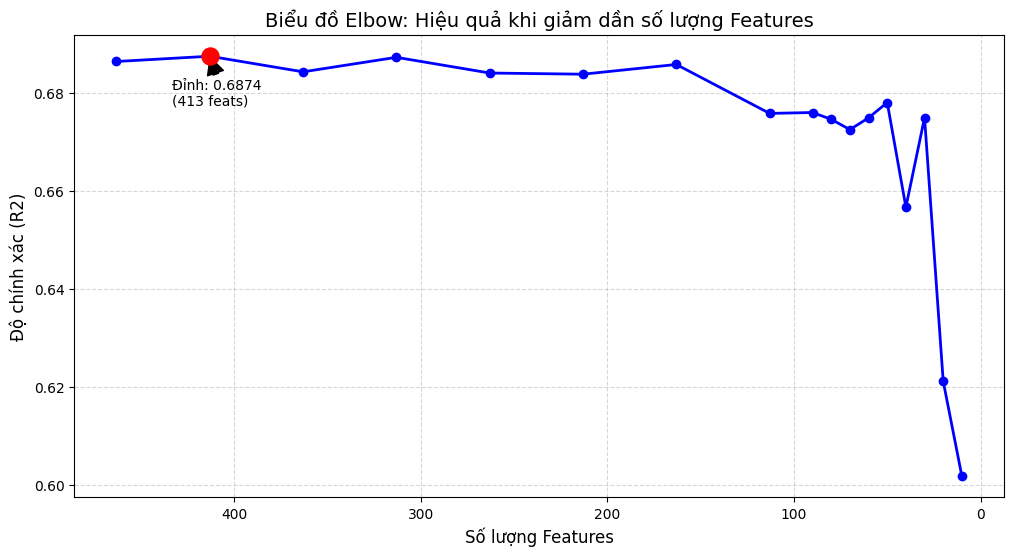


BẢNG XẾP HẠNG (SCORE GIẢM DẦN):
         R2  Num_Features        RMSE
0  0.687415           413  230.484448
1  0.687193           313  230.566515
2  0.686340           463  230.880615
3  0.685732           163  231.104097
4  0.684232           363  231.654993
5  0.683988           263  231.744450
6  0.683750           213  231.831858
7  0.677969            50  233.941064
8  0.675935            90  234.678749
9  0.675756           113  234.743707

BẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):
    Num_Features        R2        RMSE
16            10  0.601768  260.151244
15            20  0.621128  253.748865
14            30  0.674887  235.057776
13            40  0.656642  241.563443
12            50  0.677969  233.941064
11            60  0.674852  235.070529
10            70  0.672454  235.935792
9             80  0.674548  235.180366
8             90  0.675935  234.678749
7            113  0.675756  234.743707


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

print("Đang xếp hạng features...")
ranker = LGBMRegressor(**best_params)
ranker.fit(X_train[valid_ga_feats], y_train)

imp_df = pd.DataFrame({
    'Feature': valid_ga_feats,
    'Importance': ranker.feature_importances_
}).sort_values(by='Importance', ascending=False)

sorted_feats = imp_df['Feature'].tolist()

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nBắt đầu vòng lặp cắt giảm features ({len(steps)} vòng)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"   -> Dùng {k:3d} features: R2 = {r2:.4f} | RMSE = {rmse:.2f}")
    results.append({'Num_Features': k, 'R2': r2, 'RMSE': rmse})


df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
csv_filename = 'result/feature_selection_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['R2'], marker='o', linewidth=2, color='blue')

best_row = df_results.loc[df_results['R2'].idxmax()]
plt.scatter(best_row['Num_Features'], best_row['R2'], color='red', s=150, zorder=5)
plt.annotate(f"Đỉnh: {best_row['R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['R2']), 
             xytext=(best_row['Num_Features']+20, best_row['R2']-0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Biểu đồ Elbow: Hiệu quả khi giảm dần số lượng Features', fontsize=14)
plt.xlabel('Số lượng Features', fontsize=12)
plt.ylabel('Độ chính xác (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nBẢNG XẾP HẠNG (SCORE GIẢM DẦN):")
print(df_leaderboard[['R2', 'Num_Features', 'RMSE']].head(10))

print("\nBẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):")
print(df_results[['Num_Features', 'R2', 'RMSE']].head(10))

Phat hien 13 features tuong quan > 0.995
Vi du: ['Chi0n', 'Chi1', 'fr_phenol_noOrthoHbond', 'HeavyAtomCount', 'SMR_VSA_sum']
Train thu tren 924 features...
Ket qua R2 moi: 0.2554


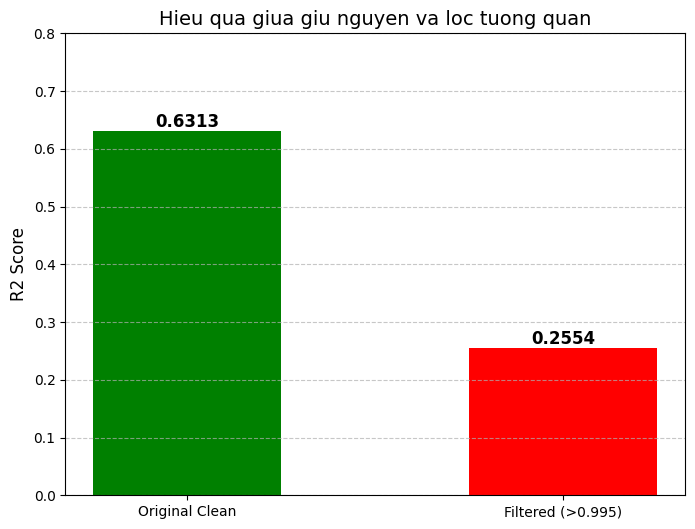

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

ULTRA_HIGH_CORR = 0.995 

corr_matrix = X_train_clean.corr().abs()

ranker_temp = LGBMRegressor(n_estimators=100, verbose=-1, random_state=42)
ranker_temp.fit(X_train_clean, y_train_clean)
importances = pd.Series(ranker_temp.feature_importances_, index=X_train_clean.columns)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = []

for column in upper.columns:
    correlated_cols = upper.index[upper[column] > ULTRA_HIGH_CORR].tolist()
    if correlated_cols:
        for other_col in correlated_cols:
            if other_col in to_drop: continue
            imp_col = importances.get(column, 0)
            imp_other = importances.get(other_col, 0)
            if imp_col < imp_other:
                to_drop.append(column)
                break 
            else:
                to_drop.append(other_col)

to_drop = list(set(to_drop))

print(f"Phat hien {len(to_drop)} features tuong quan > {ULTRA_HIGH_CORR}")
print(f"Vi du: {to_drop[:5]}")

voting_model = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    num_leaves=50,
    max_depth=-1,
    random_state=2601,
    n_jobs=1,
    verbose=-1
)

if len(to_drop) > 0:
    X_train_ultra = X_train_clean.drop(columns=to_drop)
    X_test_ultra = X_test.drop(columns=to_drop)

    print(f"Train thu tren {X_train_ultra.shape[1]} features...")
    voting_model.fit(X_train_ultra, y_train_clean)
    
    y_pred = voting_model.predict(X_test_ultra)
    new_r2 = r2_score(y_test, y_pred)
    
    old_r2 = 0.6313 
    
    print(f"Ket qua R2 moi: {new_r2:.4f}")
    
    methods = ['Original Clean', 'Filtered (>0.995)']
    scores = [old_r2, new_r2]
    colors = ['green', 'red']

    plt.figure(figsize=(8, 6))
    bars = plt.bar(methods, scores, color=colors, width=0.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title('Hieu qua giua giu nguyen va loc tuong quan', fontsize=14)
    plt.ylabel('R2 Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 0.8)
    plt.show()

else:
    print("Khong co features nao qua giong nhau de xoa.")

---

# EXTRA MODEL 
# MAE (Mean Absolute Error)

Ranking features (Fast Mode)...
Ranking done in 5.3s

Starting MAE Loop (26 steps)...
   -> Top 937 features: MAE = 118.44
   -> Top 887 features: MAE = 118.06
   -> Top 837 features: MAE = 117.91
   -> Top 787 features: MAE = 118.25
   -> Top 737 features: MAE = 118.74
   -> Top 687 features: MAE = 118.53
   -> Top 637 features: MAE = 118.39
   -> Top 587 features: MAE = 118.82
   -> Top 537 features: MAE = 118.31
   -> Top 487 features: MAE = 118.63
   -> Top 437 features: MAE = 118.84
   -> Top 387 features: MAE = 118.50
   -> Top 337 features: MAE = 118.76
   -> Top 287 features: MAE = 119.19
   -> Top 237 features: MAE = 119.09
   -> Top 187 features: MAE = 119.76
   -> Top 137 features: MAE = 119.67
   -> Top  90 features: MAE = 118.92
   -> Top  80 features: MAE = 120.61
   -> Top  70 features: MAE = 122.44
   -> Top  60 features: MAE = 121.42
   -> Top  50 features: MAE = 122.72
   -> Top  40 features: MAE = 122.83
   -> Top  30 features: MAE = 128.01
   -> Top  20 features: MA

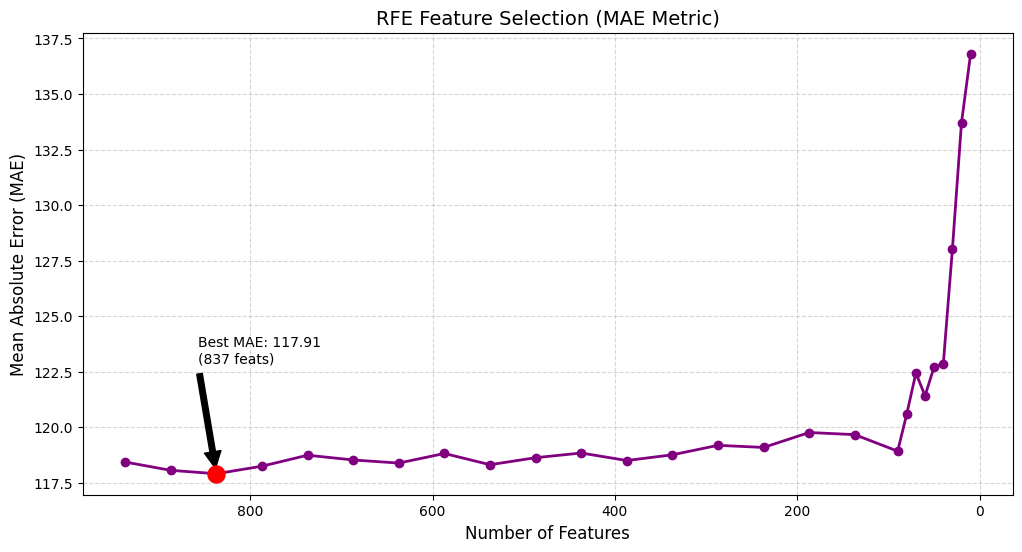


TOP 5 CONFIGURATIONS (LOWEST MAE):
   Num_Features         MAE
0           837  117.909488
1           887  118.061435
2           787  118.248507
3           537  118.314785
4           637  118.388651

LOOP PROGRESS:
    Num_Features         MAE
25            10  136.810324
24            20  133.713769
23            30  128.007277
22            40  122.825782
21            50  122.722280
20            60  121.418005
19            70  122.439477
18            80  120.606145
17            90  118.924334
16           137  119.668737


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
import time

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

fast_params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'num_leaves': 31,
    'random_state': 2601,
    'n_jobs': -1,
    'verbose': -1
}

print("Ranking features (Fast Mode)...")
start_time = time.time()

rfe_selector = RFE(estimator=LGBMRegressor(**fast_params), 
                   n_features_to_select=1, 
                   step=0.1, 
                   verbose=0)

rfe_selector.fit(X_train, y_train) 

rfe_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank': rfe_selector.ranking_
}).sort_values(by='Rank', ascending=True)

sorted_feats = rfe_df['Feature'].tolist()
print(f"Ranking done in {time.time() - start_time:.1f}s")

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nStarting MAE Loop ({len(steps)} steps)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])
    mae = mean_absolute_error(y_test, y_pred)

    print(f"   -> Top {k:3d} features: MAE = {mae:.2f}")
    results.append({'Num_Features': k, 'MAE': mae})

df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='MAE', ascending=True).reset_index(drop=True)

csv_filename = 'result/rfe_mae_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['MAE'], marker='o', linewidth=2, color='purple')

best_row = df_results.loc[df_results['MAE'].idxmin()]
plt.scatter(best_row['Num_Features'], best_row['MAE'], color='red', s=150, zorder=5)
plt.annotate(f"Best MAE: {best_row['MAE']:.2f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['MAE']), 
             xytext=(best_row['Num_Features']+20, best_row['MAE']+5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('RFE Feature Selection (MAE Metric)', fontsize=14)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nTOP 5 CONFIGURATIONS (LOWEST MAE):")
print(df_leaderboard.head(5))

print("\nLOOP PROGRESS:")
print(df_results.head(10))